In [1]:
from pydap.client import open_url
from datetime import datetime
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import pyproj
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import math
import pickle
from datetime import date
import os
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib
import cartopy as cart
from scipy import stats


def retrieve_microplastics_gt():
    lats = np.zeros(181)
    count = 90
    for i in range(len(lats)):
        lats[i] = count
        count -= 1
    for filename in os.listdir('../microplast_gt'):
        logfilename = filename[:-4] + '_log'
        try:
            df = pd.read_csv('../microplast_gt/' + filename, header=None)

        except:
            print(filename)
            continue
        longlist = []
        latlist = []
        valuelist_log = []
        valuelist = []
        for long in range(0, 361):
            for lat in range(0, 181):
                val = df[long][lat]
                if val < 1:
                    valuelist_log.append(1)
                else:
                    valuelist_log.append(np.log10(val))
                longlist.append(long)
                latlist.append(lats[lat])
                valuelist.append(val)
        if filename == "lebretonmodel_abundance.csv":
            res_df = pd.DataFrame(
                {'sp_lon': longlist, 'sp_lat': latlist, filename[:-4]: valuelist, logfilename: valuelist_log})
        else:
            res_df[filename[:-4]] = valuelist
            res_df[logfilename] = valuelist_log
    return res_df


def plot_var_2(df, var):
    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['lon'], df['lat'], c=list(df[var]))
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    plt.title('Van Sebille microplastic mass')
    ax.add_patch(matplotlib.patches.Rectangle(xy=[220, -40], width=40, height=20,
                                    alpha=1,
                                    color = 'red',
                                    fill = None,
                                    transform=ccrs.PlateCarree())
                 )
    bar.ax.set_title('[g/km^2, log10 scale]')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('region.png')
    plt.show()


def plot_var(df, var):
    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['lon'], df['lat'], c=list(df[var]))
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    bar.ax.set_title('MSS anomaly #3')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(str(var) +  '_map.png')
    plt.show()

# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 40]
    df = df[df.sp_lat >= -40]

    df_northern = df[df.sp_lat >= 20]
    df_southern = df[df.sp_lat <= -20]
    df = pd.concat([df_northern, df_southern])
    df = df[df.sp_lon >= 220]
    return df[df.sp_lon <= 260]


# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 40]
    df = df[df.sp_lat >= -40]

    df_northern = df[df.sp_lat >= 20]
    df_southern = df[df.sp_lat <= -20]
    df = pd.concat([df_northern, df_southern])
    df = df[df.sp_lon >= 220]
    return df[df.sp_lon <= 260]

def open_anomalies_csvs():
    df_list = []
    for filename in os.listdir('../-40_-20_220_260'):
        df_list.append(pd.read_csv('../-40_-20_220_260/' + filename))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)


In [2]:
mic_df = retrieve_microplastics_gt().dropna()
interp_micro_mass = LinearNDInterpolator(list(zip(mic_df['sp_lon'], mic_df['sp_lat'])), mic_df['vansebillemodel_mass_log'])
interp_micro_abu = LinearNDInterpolator(list(zip(mic_df['sp_lon'], mic_df['sp_lat'])), mic_df['vansebillemodel_abundance_log'])

.ipynb_checkpoints


KeyError: 'lon'

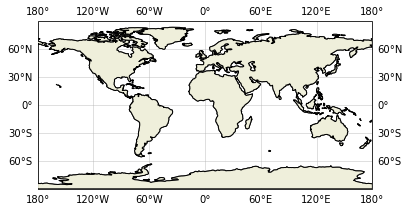

In [3]:
plot_var_2(mic_df, 'vansebillemodel_mass_log')

In [ ]:
df = open_anomalies_csvs()
df['delta'] = np.sqrt((df.wind_u10-df.current_u)**2 + (df.wind_v10-df.current_v)**2)
df['total_wind'] = np.sqrt((df.wind_u10)**2 + (df.wind_v10)**2)
df['micro_mass'] = interp_micro_mass(df['lon'], df['lat'])
df['abundace'] = interp_micro_abu(df['lon'], df['lat'])
df = df.dropna()
df

In [ ]:
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]
df

In [ ]:
df = df[df.total_wind >= 3]
df = df[df.total_wind <= 11]
latex_df = pd.DataFrame({'mss_ano_1': df.mss_anomaly_mostafa, 'mss_ano_2': df.mss_anomaly_towards, 'mss_ano_3':df.mss_anomaly_towards_delta, 'micro_mass': df.micro_mass, 'abundace': df.abundace})
latex_df

In [ ]:
latex_df = latex_df[latex_df.mss_ano_3 <= 1]
latex_df = latex_df[latex_df.mss_ano_3 >= -1]

In [ ]:
first_n_column  = df.iloc[: , :5]
first_n_column['lon'] = first_n_column['lon'].round(0).astype(int)
first_n_column['lat'] = first_n_column['lat'].round(0).astype(int)
first_n_column = first_n_column.groupby(['lon', 'lat'], as_index=False)[['mss_anomaly_mostafa', 'mss_anomaly_towards', 'mss_anomaly_towards_delta']].mean()
mass = interp_micro_mass(first_n_column['lon'], first_n_column['lat'])
abu = interp_micro_abu(first_n_column['lon'], first_n_column['lat'])
first_n_column['micro_mass'] = mass
first_n_column['abundace'] = abu
first_n_column

In [ ]:
latex_df_2 = pd.DataFrame({'mss_ano_1': first_n_column.mss_anomaly_mostafa, 'mss_ano_2': first_n_column.mss_anomaly_towards, 'mss_ano_3':first_n_column.mss_anomaly_towards_delta, 'micro_mass': first_n_column.micro_mass, 'abundace': first_n_column.abundace, 'lon' : first_n_column.lon, 'lat': first_n_column.lat}) 
latex_df_2 = latex_df_2[latex_df_2.mss_ano_1 <= 0.1]
latex_df_2 = latex_df_2[latex_df_2.mss_ano_1 >= -0.1]
latex_df_2.corr()

In [ ]:
latex_df_2 = pd.DataFrame({'mss_ano_1': first_n_column.mss_anomaly_mostafa, 'mss_ano_2': first_n_column.mss_anomaly_towards, 'mss_ano_3':first_n_column.mss_anomaly_towards_delta, 'micro_mass': first_n_column.micro_mass, 'abundace': first_n_column.abundace}) 
latex_df_2 = latex_df_2[latex_df_2.mss_ano_1 <= 0.1]
latex_df_2 = latex_df_2[latex_df_2.mss_ano_1 >= -0.1]
print(latex_df_2.corr().to_latex())

In [ ]:
plot_var_2(latex_df_2, 'micro_mass')
#plot_var(latex_df_2, 'mss_ano_1')
#plot_var(latex_df_2, 'mss_ano_2')
plot_var(latex_df_2, 'mss_ano_3')

In [ ]:
fig = px.density_heatmap(latex_df_2, y="micro_mass", x="mss_ano_1", nbinsx = 50, nbinsy = 50, color_continuous_scale=px.colors.sequential.Blackbody)
fig.update_layout(
    xaxis_title= r"$\text{MSS anomaly #3}$",
    yaxis_title= r"$\text{Microplastic mass, (g/km^2, log10 scale)}$",
    legend_title="Legend Title",
    font=dict(size=25,),
)
fig.show()

In [ ]:
bin_df = pd.DataFrame({'mss':latex_df_2.mss_ano_3, 'micro' : latex_df_2.micro_mass })
bin_df['mss_ano'] = pd.cut(bin_df['mss'], bins = np.linspace(bin_df.mss.min(), bin_df.mss.max(), 30)).apply(lambda x: x.left)
bin_df

In [ ]:
mean_micro_by_bin = bin_df.groupby(['mss_ano'], as_index=False)['micro'].mean()
mean_micro_by_bin
plt.step(
    mean_micro_by_bin['mss_ano'],
    mean_micro_by_bin['micro'],
    where='mid',
)
plt.xlabel('MSS anomaly #3')
plt.ylabel('Microplastic mass, (g/km^2, log10 scale)')
plt.savefig('mss_ano_3.png')
plt.show()

In [ ]:
from catboost import CatBoostRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

# plot the dataset and the model's line of best fit
def plot_best_fit(X, y, model):
    # fut the model on all data
    model.fit(X, y)
    # plot the dataset
    plt.scatter(X, y)
    # plot the line of best fit
    xaxis = np.arange(X.min(), X.max(), 0.01)
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))
    plt.plot(xaxis, yaxis, color='r')
    # show the plot
    plt.title(type(model).__name__)
    plt.show()
# define the model
model = LinearRegression()
model = CatBoostRegressor(verbose = False)
plot_best_fit(np.array(df.mss_anomaly_mostafa).reshape(-1, 1), df.micro_mass, model)

In [ ]:
#latex_df = latex_df[latex_df.mss_ano_3 <= 1]
#latex_df = latex_df[latex_df.mss_ano_3 >= -1]
fig = px.density_heatmap(latex_df_2, y="micro_mass", x="mss_ano_3", nbinsx = 50, nbinsy = 50, color_continuous_scale=px.colors.sequential.Blackbody)
fig.update_layout(
    xaxis_title= r"$\text{MSS anomaly #3}$",
    yaxis_title= r"$\text{Microplastic mass, (g/km^2, log10 scale)}$",
    legend_title="Legend Title",
    font=dict(
        size=16,
    )
)
fig.show()